**<font color=black size=5 face=雅黑>引入第三方库</font>**

In [79]:
import re,math
from math import log
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn import datasets, metrics, model_selection, svm
from itertools import groupby
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import urllib

**<font color=black size=5 face=雅黑>数据的获取，读取csv文件</font>**

In [80]:
CSV_FILE_PATH = './work/data.csv'
df = pd.read_csv(CSV_FILE_PATH)
print(df.head())
print(df.tail())
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei',font_scale=1.0)  # 解决Seaborn中文显示问题并调整字体大小


                                           data  target
0                                  1 AND 1=1%00       1
1                    1 AND %00%271%00%27=%00%27       1
2  1%23PTTmJopxdWJ%0AAND%23cWfcVRPV%0A9227=9227       1
3                       1 AND GREATEST(A,B+1)=A       1
4     1--nVNaVoPYeva%0AAND--ngNvzqu%0A9227=9227       1
                                                   data  target
9944  r%3D%5B4%2C75%2C16%2C75%2C3%5D%26a%3D%5B30%2C7...       0
9945                      z%3Difeng%26c%3D1%26l%3D53150       0
9946  vkey%3D193245C191BE8FCA8CBA22A7136DFB5D46AE5E6...       0
9947  oid%3D1805171983%26cid%3D732388888%26loc%3DAll...       0
9948  _iwt_UA%3DUA-qq-120001%26jsonp%3DSetIDA0%26_iw...       0


**<font color=black size=5 face=雅黑>对数据进行url解码并都变为小写字母</font>**

In [81]:
def unquote(url):
    url = urllib.parse.unquote(url)
    url = url.lower()
    return url
df['data_after_unquote'] = df['data'].apply(unquote)
print(df['data_after_unquote'].head())
print(df['data_after_unquote'].tail())

0                                 1 and 1=1 
1                             1 and  '1 '= '
2     1#pttmjopxdwj\nand#cwfcvrpv\n9227=9227
3                    1 and greatest(a,b+1)=a
4    1--nvnavopyeva\nand--ngnvzqu\n9227=9227
Name: data_after_unquote, dtype: object
9944    r=[4,75,16,75,3]&a=[30,71,58,85,71,95,62,92,86...
9945                                  z=ifeng&c=1&l=53150
9946    vkey=193245c191be8fca8cba22a7136dfb5d46ae5e6bd...
9947    oid=1805171983&cid=732388888&loc=allinone_15_u...
9948    _iwt_ua=ua-qq-120001&jsonp=setida0&_iwt_vid=dh...
Name: data_after_unquote, dtype: object


**<font color=black size=5 face=雅黑>特征一：空格所占长度的比例</font>**

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


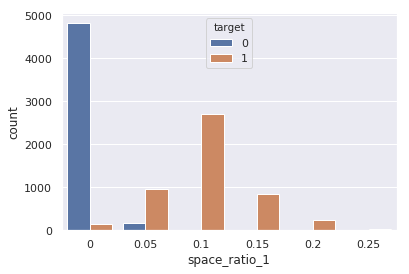

In [82]:
def space_ratio(data):
    count = 0
    for i in data:
        if i is " ":
            count += 1
    allnum = len(data)
    ratio = count / allnum
    return ratio
df['space_ratio'] = df['data_after_unquote'].apply(space_ratio)
df['space_ratio_1'] = pd.cut(df['space_ratio'], bins=[-0.1,0, 0.05, 0.1, 0.15,0.2,0.25], labels=['0','0.05', '0.1', '0.15','0.2','0.25'])
sns.countplot(x='space_ratio_1', hue='target',data=df)

**<font color=black size=5 face=雅黑>特征二：关键字的数量</font>**

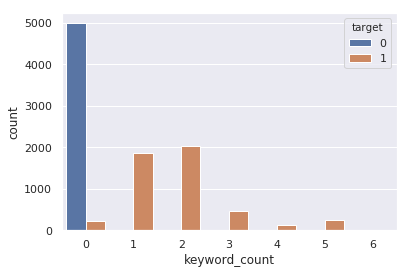

In [83]:
def keyword_count(data):
    keywordlist = ['select','union','count(','group by','order by','insert into', 'create ','declare ','delete ','update ','drop ','truncate','and ','or ','where ','from ','into ','exec','master','load_file','outfile','dumpfile']
    count = 0
    for i in keywordlist:
        if i in data:
            count = count+1
    return count
df['keyword_count'] = df['data_after_unquote'].apply(keyword_count)
sns.countplot(x='keyword_count', hue='target',data=df)

**<font color=black size=5 face=雅黑>特征三：关键字长度占总长度比例</font>**

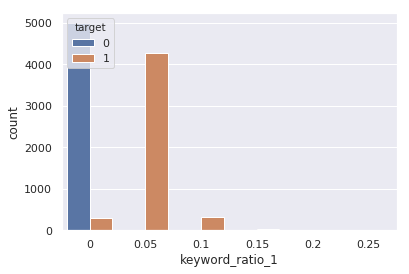

In [84]:
def keyword_ratio(data):
    keywordlist = ['select ','union ','count ','group by ','order by ','insert ', 'create ','declare ','set ','delete ','update ','drop ','truncate ','and ','or ','where ','from ','into ','exec xp_cmdshell','master ','net ','load_file ','outfile ','dumpfile ']
    count = 0
    for i in keywordlist:
        if i in data:
            count = count+1
    allcount = len(data)
    keyword_ratio = count/allcount
    return keyword_ratio
df['keyword_ratio'] = df['data_after_unquote'].apply(keyword_ratio)
df['keyword_ratio_1'] = pd.cut(df['keyword_ratio'], bins=[-0.1,0, 0.05, 0.1, 0.15,0.2,0.25], labels=['0','0.05', '0.1', '0.15','0.2','0.25'])
sns.countplot(x='keyword_ratio_1', hue='target',data=df)

**<font color=black size=5 face=雅黑>特征四：特殊字符的数量</font>**

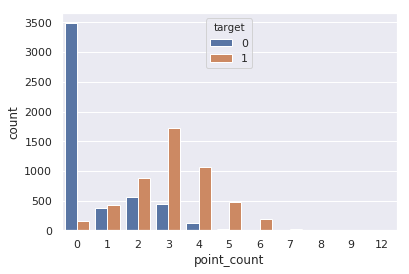

In [95]:
def special_word_count(data):
    special_wordlist = ['+','-','*','||', '!=','^=','<','>','-','#','/*','*/','\'','\"','@','\\','(',')']
    count = 0
    for i in special_wordlist:
        if i in data:
            count = count+1
    return count
df['point_count'] = df['data_after_unquote'].apply(special_word_count)
sns.countplot(x='point_count', hue='target',data=df)

**<font color=black size=5 face=雅黑>特征五：特殊字符长度占总长度比例</font>**

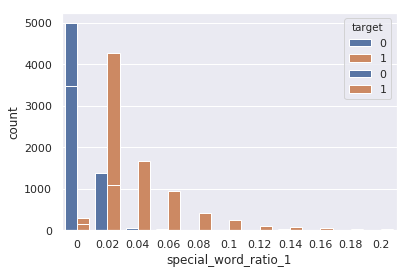

In [ ]:
def special_word_ratio(data):
    special_wordlist = ['+','-','*','||', '!=','^=','<','>','-','#','/*','*/','\'','\"','@','\\','(',')']
    count = 0
    for i in special_wordlist:
        if i in data:
            count = count+1
    allcount = len(data)
    ratio = count/allcount
    return ratio
df['special_word_ratio'] = df['data_after_unquote'].apply(special_word_ratio)
df['special_word_ratio_1'] = pd.cut(df['special_word_ratio'], bins=[-0.1,0,0.02, 0.04, 0.06, 0.08,0.1,0.12,0.14,0.16,0.18,0.2], labels=['0','0.02', '0.04', '0.06','0.08','0.1','0.12','0.14','0.16','0.18','0.2'])
sns.countplot(x='keyword_ratio_1', hue='target',data=df)
sns.countplot(x='special_word_ratio_1', hue='target',data=df)

**<font color=black size=5 face=雅黑>特征六：有绕过的特征</font>**

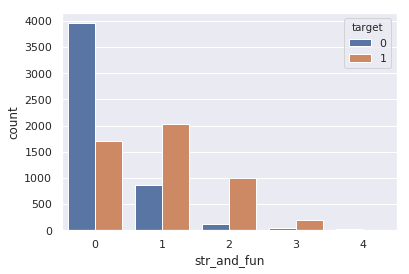

In [96]:
def bypass(data):
    list = ['and','or','0=','0<','1=','1<','1>','2=','2<','2>','1\'=']
    count = 0
    for i in list:
        if i in data:
            count = count+1
    return count
df['str_and_fun'] = df['data_after_unquote'].apply(bypass)
sns.countplot(x='str_and_fun', hue='target',data=df)


**<font color=black size=5 face=雅黑>特征七：有无“ ' ”</font>**

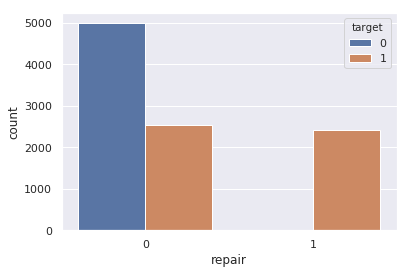

In [97]:
def point(data):
    if "\'" in data:
        return 1
    else:
        return 0
df['repair'] = df['data_after_unquote'].apply(point)
sns.countplot(x='repair', hue='target',data=df)


**<font color=black size=5 face=雅黑>特征八：长度</font>**

In [ ]:
def lenth(data):
    l = len(data)
    return l
df['length'] = df['data_after_unquote'].apply(lenth)
# print(df['length'].head())
# print(df['length'].tail())
df['target_cut'] = pd.cut(df['target'],bins=[-0.5,0.5,1.5],labels=['good', 'malicous'])
count = df.groupby(['length','target_cut']).size().reset_index(name='Count')
sns.pointplot(x = 'length', y = 'Count', hue = 'target_cut', data = count,markerscale=1.)
plt.title('Lenth Count By target')
plt.xticks(())


([], <a list of 0 Text xticklabel objects>)

**<font color=black size=5 face=雅黑>特征九：信息熵</font>**

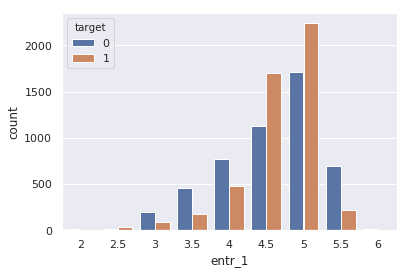

In [98]:
def entropy(data):
    #信息熵，表示字符串的随机程度
    numEntries = len(data)
    labelCounts = {}
    for featVec in data:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel]=0
        labelCounts[currentLabel]+=1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2)
    return shannonEnt
df['entr'] = df['data_after_unquote'].apply(entropy)
df['entr_1'] = pd.cut(df['entr'], bins=[1.5,2,2.5,3,3.5,4,4.5,5,5.5,6], labels=['2','2.5','3','3.5','4','4.5','5','5.5','6'])
sns.countplot(x='entr_1', hue='target',data=df)

**<font color=black size=5 face=雅黑>特征十：数字占的比例</font>**

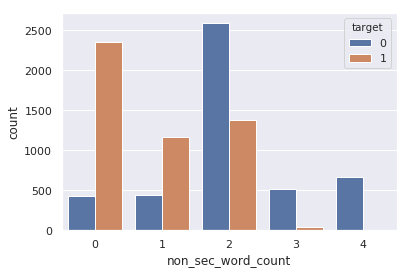

In [105]:
def number_ratio(data):
    count = 0
    for i in data:
        if i.isdigit() is True:
            count += 1
    allnum = len(data)
    ratio = count / allnum
    return ratio
df['number_ratio'] = df['data_after_unquote'].apply(number_ratio)
df['non_sec_word_count'] = pd.cut(df['number_ratio'], bins=[-0.1,0.15, 0.22, 0.5, 0.6,0.8], labels=['0','1', '2', '3','4'])
sns.countplot(x='non_sec_word_count', hue='target',data=df)

**<font color=black size=5 face=雅黑>将处理后的特征写入CSV文件</font>**

In [45]:
print(df.head())
print(df.tail())
# 写入excel文件
df.to_csv("./work/data_after_pro.csv",index=False,sep=',')

                                           data  target  \
0                                  1 AND 1=1%00       1   
1                    1 AND %00%271%00%27=%00%27       1   
2  1%23PTTmJopxdWJ%0AAND%23cWfcVRPV%0A9227=9227       1   
3                       1 AND GREATEST(A,B+1)=A       1   
4     1--nVNaVoPYeva%0AAND--ngNvzqu%0A9227=9227       1   

                        data_after_unquote  space_ratio space_ratio_1  \
0                               1 and 1=1      0.200000           0.2   
1                           1 and  '1 '= '     0.142857          0.15   
2   1#pttmjopxdwj\nand#cwfcvrpv\n9227=9227     0.000000             0   
3                  1 and greatest(a,b+1)=a     0.086957           0.1   
4  1--nvnavopyeva\nand--ngnvzqu\n9227=9227     0.000000             0   

   keyword_count  keyword_ratio keyword_ratio_1  special_word_count  \
0              1       0.100000             0.1                   0   
1              1       0.071429             0.1                 

**<font color=black size=5 face=雅黑>热力图查看特征之间的相关性</font>**

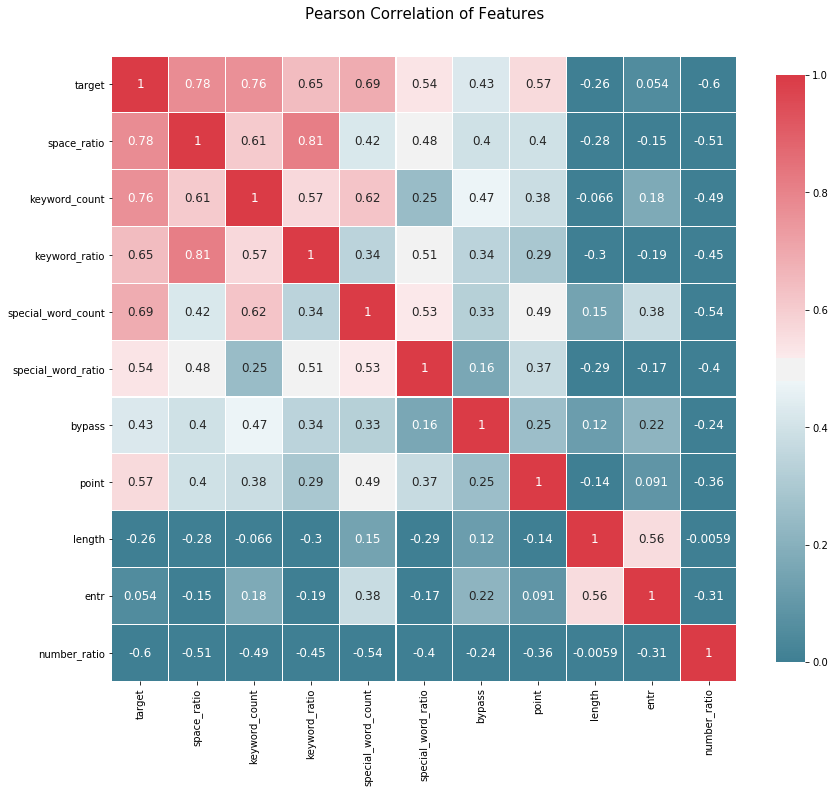

In [46]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    _ = sns.heatmap(df.corr(),cmap = colormap, square=True,cbar_kws={'shrink':.9 }, ax=ax, annot=True, linewidths=0.1,vmin=0,vmax=1.0, linecolor='white',annot_kws={'fontsize':12 })
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    plt.show()
correlation_heatmap(df)

**<font color=black size=5 face=雅黑>训练模型数据集导入并分割训练集和测试集</font>**

In [47]:
data_lite = df[['space_ratio', 'keyword_count', 'keyword_ratio' , 'special_word_count', 'special_word_ratio', 'bypass','point','length','entr','number_ratio','target']]
# 下面看一下数据的前五行是不是我们想要的结果
data_dummies = data_lite
print(data_lite.head())
features = data_dummies.loc[:,'space_ratio':'number_ratio']
X = features.values
y = data_dummies['target'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=9)  # 拆分成训练集和测试集

   space_ratio  keyword_count  keyword_ratio  special_word_count  \
0     0.200000              1       0.100000                   0   
1     0.142857              1       0.071429                   1   
2     0.000000              0       0.000000                   1   
3     0.086957              1       0.043478                   3   
4     0.000000              0       0.000000                   2   

   special_word_ratio  bypass  point  length      entr  number_ratio  target  
0            0.000000       2      0      10  2.646439      0.300000       1  
1            0.071429       1      1      14  2.842371      0.142857       1  
2            0.027778       1      0      36  4.260067      0.250000       1  
3            0.130435       1      0      23  3.827910      0.086957       1  
4            0.054054       1      0      37  3.956358      0.243243       1  


**<font color=black size=8 face=雅黑>随机森林调参过程</font>**

**<font color=black size=5 face=雅黑>随机森林调参：criterion参数的最佳值</font>**

In [48]:
# RF = RandomForestClassifier(random_state = 66)
# score = cross_val_score(RF,X_train,y_train,cv=10).mean()
# print('基尼系数得分: %.4f'%score)
# RF = RandomForestClassifier(criterion = 'entropy',random_state = 66)
# score = cross_val_score(RF,X_train,y_train,cv=10).mean()
# print('熵得分: %.4f'%score)

**<font color=black size=5 face=雅黑>随机森林调参：探索n_estimators的最佳值</font>**

In [49]:
# ###调n_estimators参数
# ScoreAll = []
# for i in range(10,101,10):
#     DT = RandomForestClassifier(n_estimators = i,random_state = 66,criterion = 'entropy') 
#     score = cross_val_score(DT,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)
# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()

###调n_estimators参数
# ScoreAll = []
# for i in range(40,60,1):
#     DT = RandomForestClassifier(n_estimators = i,random_state = 66,criterion = 'entropy') 
#     score = cross_val_score(DT,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)
# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()



**<font color=black size=5 face=雅黑>随机森林调参：探索max_depth（树的最大深度）最佳参数</font>**

In [50]:
# ###粗调max_depth参数
# ScoreAll = []
# for i in range(5,15,1):
#     DT = RandomForestClassifier(n_estimators = 45,random_state = 66,max_depth =i,criterion = 'entropy') 
#     score = cross_val_score(DT,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)

# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()

**<font color=black size=5 face=雅黑>随机森林调参：探索min_samples_split（分割内部节点所需的最小样本数）最佳参数</font>**

In [51]:
# ###调min_samples_split参数
# ScoreAll = []
# for i in range(2,10,1):
#     RF = RandomForestClassifier(n_estimators = 45,max_depth = 10,random_state = 66,min_samples_split = i,criterion = 'entropy' ) #,criterion = 'entropy'
#     score = cross_val_score(RF,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)

# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()

**<font color=black size=5 face=雅黑>随机森林调参：探索min_samples_leaf（分割内部节点所需的最小样本数）最佳参数</font>**

In [52]:
# ###调min_samples_leaf参数
# ScoreAll = []
# for i in range(1,10,1):
#     DT = RandomForestClassifier(n_estimators = 45,max_depth = 10,random_state = 66,min_samples_leaf = i,min_samples_split = 2,criterion = 'entropy' ) 
#     score = cross_val_score(DT,X_train,y_train,cv=10).mean()
#     ScoreAll.append([i,score])
# ScoreAll = np.array(ScoreAll)

# max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##找出最高得分对应的索引
# print("最优参数以及最高得分:",ScoreAll[max_score])  
# plt.figure(figsize=[20,5])
# plt.plot(ScoreAll[:,0],ScoreAll[:,1])
# plt.show()

**<font color=black size=5 face=雅黑>随机森林调参：对每棵树用到的最大特征数max_features调参</font>**

In [53]:
#调max_features参数
list =['auto','sqrt','log2']
ScoreAll = []
for i in list:
    DT = RandomForestClassifier(n_estimators = 45,max_depth = 10,random_state = 66,min_samples_leaf = 1,min_samples_split = 2,criterion = 'entropy',max_features= i  ) 
    score = cross_val_score(DT,X_train,y_train,cv=10).mean()
    ScoreAll.append([i,score])
    print(i,score)
DT = RandomForestClassifier(n_estimators = 45,max_depth = 10,random_state = 66,min_samples_leaf = 1,min_samples_split = 2,criterion = 'entropy',max_features= None  ) 
score = cross_val_score(DT,X_train,y_train,cv=10).mean()
ScoreAll.append([i,score])
print("None",score)

auto 0.9979903603955999
sqrt 0.9979903603955999
log2 0.9979903603955999
None 0.9972727941428582


**<font color=black size=5 face=雅黑>随机森林模型训练</font>**

In [54]:
# 经过调参后，用25棵树最大深度为10的随机森林拟合数据
forest = RandomForestClassifier(n_estimators=45,max_depth=10, criterion='entropy', random_state=66, min_samples_split = 2,min_samples_leaf=1)
forest.fit(X_train, y_train)
# 模型的评估
y_test_pre = forest.predict(X_test)
test_accuracy = forest.score(X_test, y_test)
score = cross_val_score(forest,X_train,y_train,cv=10).mean()
print(score)
print("这里是随机森林模型的评估：")
print("\n测试集的准确率：", test_accuracy)
test_precision = precision_score(y_test, y_test_pre)
print("\n测试集的精确率：", test_precision)
test_recall = recall_score(y_test, y_test_pre)
print("\n测试集的召回值：", test_recall)
test_f1 = f1_score(y_test, y_test_pre)
print("\n测试集的F1值：", test_f1)
print("\n测试集的漏报率：", 1-test_recall)
print("\n测试集的误报率：", 1-test_precision)
print("\n")
print(classification_report(y_test,y_test_pre))


0.9979903603955999
这里是随机森林模型的评估：

测试集的准确率： 0.9966499162479062

测试集的精确率： 0.998645903859174

测试集的召回值： 0.9946055293324343

测试集的F1值： 0.9966216216216216

测试集的漏报率： 0.0053944706675657095

测试集的误报率： 0.0013540961408260443


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1502
           1       1.00      0.99      1.00      1483

   micro avg       1.00      1.00      1.00      2985
   macro avg       1.00      1.00      1.00      2985
weighted avg       1.00      1.00      1.00      2985



**<font color=black size=5 face=雅黑>特征重要度排序</font>**

这里是特征的重要度排序：

Index(['space_ratio', 'keyword_count', 'keyword_ratio', 'special_word_count',
       'special_word_ratio', 'bypass', 'point', 'length', 'entr',
       'number_ratio'],
      dtype='object')
 1) space_ratio                    0.363369
 2) keyword_count                  0.296883
 3) keyword_ratio                  0.134828
 4) special_word_ratio             0.088505
 5) point                          0.038891
 6) special_word_count             0.027112
 7) number_ratio                   0.020683
 8) length                         0.017623
 9) entr                           0.010963
10) bypass                         0.001145


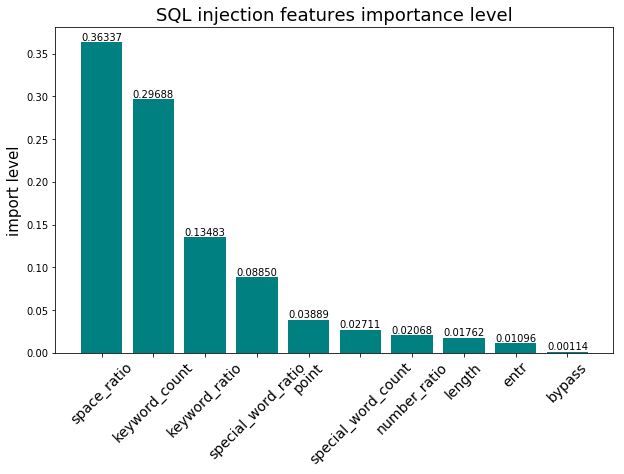

In [55]:
print("这里是特征的重要度排序：\n")
feat_labels = data_lite.columns[0:-1]
print(feat_labels)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

# 可视化
x_columns = data_lite.columns[0:-1]
plt.figure(figsize=(10,6))
plt.title("SQL injection features importance level",fontsize = 18)
plt.ylabel("import level",fontsize = 15,rotation=90)
for i in range(x_columns.shape[0]):
    plt.bar(i,importances[indices[i]],color='teal',align='center')
    plt.xticks(np.arange(x_columns.shape[0]),feat_labels[indices],rotation=45,fontsize=14)
index=np.arange(10)
num_list = importances[indices]
for a,b in zip(index,num_list):   #柱子上的数字显示
    plt.text(a,b,'%.5f'%b,ha='center',va='bottom',fontsize=10);
plt.show()

**<font color=black size=5 face=雅黑>决策树模型的训练及分数评估</font>**

In [56]:
#用最大深度为15的决策树拟合数据
go_dating_tree = tree.DecisionTreeClassifier(max_depth=15)
go_dating_tree.fit(X_train,y_train)
# 模型的评估
y_test_pre = go_dating_tree.predict(X_test)
test_accuracy = go_dating_tree.score(X_test, y_test)
print("这里是决策树模型的评估：")
print("\n测试集的准确率：", test_accuracy)
test_precision = precision_score(y_test, y_test_pre)
print("\n测试集的精确率：", test_precision)
test_recall = recall_score(y_test, y_test_pre)
print("\n测试集的召回值：", test_recall)
test_f1 = f1_score(y_test, y_test_pre)
print("\n测试集的F1值：", test_f1)
print("\n测试集的漏报率：", 1-test_recall)
print("\n测试集的误报率：", 1-test_precision)
print(classification_report(y_test,y_test_pre))

这里是决策树模型的评估：

测试集的准确率： 0.9946398659966499

测试集的精确率： 0.9952734638757597

测试集的召回值： 0.9939312204989885

测试集的F1值： 0.9946018893387315

测试集的漏报率： 0.006068779501011479

测试集的误报率： 0.004726536124240344
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1502
           1       1.00      0.99      0.99      1483

   micro avg       0.99      0.99      0.99      2985
   macro avg       0.99      0.99      0.99      2985
weighted avg       0.99      0.99      0.99      2985



**<font color=black size=5 face=雅黑>KNN模型的训练及分数评估</font>**

In [57]:
knc = KNN(n_neighbors=6, )
knc.fit(X_train, y_train)
y_predict = knc.predict(X_test)
acc = knc.score(X_test, y_test)
print('\nKNN准确率', acc)
pre = precision_score(y_test, y_predict, average='macro')
print('\nKNN精确率', pre)
recall = recall_score(y_test, y_predict, average='macro')
print('\nKNN召回率', recall)
print('\nKNNF1值', f1_score(y_test, y_predict, average='macro'))
print("\n测试集的漏报率：", 1-recall)
print("\n测试集的误报率：", 1-pre)
print(classification_report(y_test,y_test_pre))


KNN准确率 0.9849246231155779

KNN精确率 0.9849319834784951

KNN召回率 0.9849176149041108

KNNF1值 0.9849238041824111

测试集的漏报率： 0.015082385095889217

测试集的误报率： 0.015068016521504912
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1502
           1       1.00      0.99      0.99      1483

   micro avg       0.99      0.99      0.99      2985
   macro avg       0.99      0.99      0.99      2985
weighted avg       0.99      0.99      0.99      2985



**<font color=black size=5 face=雅黑>随机森林模型对手动输入的语句进行预测</font>**

In [58]:
# 预测过程
print("请输入您要检测的数据：")
input1 = input()
# 生成预测域名的特征集
predictlist = [[space_ratio(input1), keyword_count(input1),keyword_ratio(input1), special_word_count(input1), special_word_ratio(input1), bypass(input1),point(input1),lenth(input1), entropy(input1),number_ratio(input1)]]
#使用模型做出预测
dating_dec = forest.predict(predictlist)
print('\n')
print('目标%s的预测结果如下：'%input1)
print('====================================\n')
if dating_dec == 1:
    print("警告！%s是个SQL注入语句！"%input1)
else:
    print("%s为正常数据。"%input1)
print('\n====================================')
print('\n\n\n')

请输入您要检测的数据：
